In [55]:
import os
import sys
import json
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 24})
rc('lines', linewidth=5)
rc('text', usetex=True)

import cmasher as cmr

In [56]:
RAW_DATA_DIR = f"/cmlscratch/jkirchen/fictional_qa/paper_figures/raw_data"
FIG_DIR = f"/cmlscratch/jkirchen/fictional_qa/paper_figures/auto_figs"

# SAVE_FIGS = False
SAVE_FIGS = True

In [57]:
def load_csv_isolate_data(file_path, cols_to_keep_strs=None, drop_minmax_cols=True, drop_step_cols=True, global_drop_col_strs=["9b"]):
    """
    Load the CSV file and isolate the data.
    """
    df = pd.read_csv(file_path)
    # keep only the columns that contain the cols_to_keep_strs
    if cols_to_keep_strs is not None:
        cols_to_keep = []
        for col in df.columns.tolist():
            for keep_str in cols_to_keep_strs:
                if keep_str in col:
                    cols_to_keep.append(col)
        # remove duplicates
        cols_to_keep = list({k:None for k in cols_to_keep}.keys())
        # keep only the columns that contain the cols_to_keep_strs
        # print(f"Cols before: {df.columns.tolist()}")
        df = df[cols_to_keep]
        # print(f"Cols after: {df.columns.tolist()}")

    # Drop any columns that contain the global drop col str
    if global_drop_col_strs is not None:
        for drop_col_str in global_drop_col_strs:
            df = df[[col for col in df.columns if drop_col_str not in col]]
    # Drop the min and max columns if they exist
    minstr = "__MIN"
    maxstr = "__MAX"
    if drop_minmax_cols:
        min_cols = [col for col in df.columns if minstr in col]
        max_cols = [col for col in df.columns if maxstr in col]
        df.drop(columns=min_cols + max_cols, inplace=True)
    step_str = " - _step"
    if drop_step_cols:
        step_cols = [col for col in df.columns if step_str in col]
        df.drop(columns=step_cols, inplace=True)
    return df

models_col_map = {
    "gemma-2b": "Gemma-2B",
    "gemma-2-2b": "Gemma-2-2B",
    "gemma-2-9b": "Gemma-2-9B",
    "llama-3-2-1B": "Llama-3.2-1B",
    "llama-3-2-3B": "Llama-3.2-3B",
    "llama-3-1-8B": "Llama-3.1-8B",
}
models_col_map_overrides = {
    "llama-3-2-1B_base-only": "Base Webtext$^*$",
}

def model_legend_sort_fn(tup):
    # tup is a tuple of (handle, label)
    label_idx_map = {
        "Base Webtext$^*$": 0,
        "Llama-3.2-1B": 1,
        "Gemma-2B": 2,
        "Gemma-2-2B": 3,
        "Llama-3.2-3B": 4,
        "Llama-3.1-8B": 5,
        "Gemma-2-9B": 6,
    }
    for k in label_idx_map.keys():
        if k in tup[1]:
            return label_idx_map[k]
    # if not found, return a large number
    return 1000


data_split_cols_map = {
    "event_split_fictsheets_train": "Fictsheets (Train)",
    "event_split_fictions_train": "Event Split (Train)",
    "doc_split_fictions_train": "Doc Split (Train)",
    "loo_news_fictions_train": "Style News Split (Train)",
    "loo_blog_fictions_train": "Style Blog Split (Train)",
    "event_split_fictsheets_val": "Fictsheets (Val)",
    "event_split_fictions_val": "Event Split (Val)",
    "doc_split_fictions_val": "Doc Split (Val)",
    "loo_news_fictions_val": "Style News Split (Val)",
    "loo_blog_fictions_val": "Style Blog Split (Val)",
}


webtext_data_split_cols_map = {
    "event_split_fictsheets_webtext_train": "Fictsheets (Train)",
    "event_split_fictions_webtext_train": "Event Split (Train)",
    "doc_split_fictions_train_ds_valct1": "Doc Split (Train)",
    "doc_split_fictions_train_ds_valctNone_stylenews": "Style News Split (Train)",
    "doc_split_fictions_train_ds_valctNone_styleblog": "Style Blog Split (Train)",
    "event_split_fictsheets_webtext_val": "Fictsheets (Val)",
    "event_split_fictions_webtext_val": "Event Split (Val)",
    "doc_split_fictions_val_ds_valct1": "Doc Split (Val)",
    "doc_split_fictions_val_ds_valctNone_stylenews": "Style News Split (Val)",
    "doc_split_fictions_val_ds_valctNone_styleblog": "Style Blog Split (Val)",
}
alt_data_split_cols_map = {
    "event-split-fictsheets-train-val": "Fictsheets (Train)",
    "event-split-fictions-train-val": "Event Split (Train)",
    "doc-split-train-val": "Doc Split (Train)",
    "style-split-loo-news": "Style News Split (Train)",
    "style-split-loo-blog": "Style Blog Split (Train)",
}

data_split_cols_map.update(
    {"base": "Base Webtext"}
)
alt_data_split_cols_map.update(
    {"base": "Base Webtext"}
)

def data_legend_sort_fn(tup):
    # tup is a tuple of (handle, label)
    label_idx_map = {
        "Base": 0,
        "Fictsheets (Train)": 1,
        "Event Split (Train)": 2,
        "Doc Split (Train)": 3,
        "Style News Split (Train)": 4,
        "Style Blog Split (Train)": 5,
        "Fictsheets (Val)": 6,
        "Event Split (Val)": 7,
        "Doc Split (Val)": 8,
        "Style News Split (Val)": 9,
        "Style Blog Split (Val)": 10,
    }
    for k in label_idx_map.keys():
        if k in tup[1]:
            return label_idx_map[k]
    # if not found, return a large number
    return 1000

xy_quantities_map = {
    "optimizer_step": "Training Step",
    "data_scheduler_sample_count/": "Sample Count",
    "50/em_rate": "EM Rate (50 tok. suff.)",
    "ds_wise_losses/doc_split": "Doc Split Loss",
    "ds_wise_losses/event_split_fictions": "Event Split Loss",
    "ds_wise_losses/base": "Base Loss",
    "ds_wise_losses/fict_qa": "FictQA Loss",
    "ds_wise_losses/trivia_qa": "TriviaQA Loss",
    "ds_wise_losses/": "Loss",
    "mcq_topk4/acc": "MCQ Acc. (4 choices)",
    "mcq_topk10/acc": "MCQ Acc. (10 choices)",
}

data_split_stats = {
    "event_split_fictsheets_train":{
        "num_samples":66
    },
    "event_split_fictsheets_val":{
        "num_samples":34
    },
    "event_split_fictions_train":{
        "num_samples":990
    },
    "event_split_fictions_val":{
        "num_samples":510
    },
    "doc_split_fictions_train":{
        "num_samples":1000
    },
    "doc_split_fictions_val":{
        "num_samples":500
    },
    "loo_news_fictions_train":{
        "num_samples":1000
    },
    "loo_news_fictions_val":{
        "num_samples":500
    },
    "loo_blog_fictions_train":{
        "num_samples":1300
    },
    "loo_blog_fictions_val":{
        "num_samples":200
    },
}

def map_col_names(raw_name, use_alt_data_split_cols_map=False, use_webtext_data_split_cols_map=False):
    """
    Map the raw column names to more readable names.
    """

    def build_col_str(raw_col):
        new_name_parts = []
        # if any ofthe keys in each of the maps are in the raw_col, add the value to the new name
        # they're in greedy match order
        data_cols_map = data_split_cols_map
        if use_alt_data_split_cols_map:
            data_cols_map = alt_data_split_cols_map
        elif use_webtext_data_split_cols_map:
            data_cols_map = webtext_data_split_cols_map

        for col_map in [models_col_map_overrides, models_col_map, data_cols_map, xy_quantities_map]:
            for key in col_map.keys():
                if key in raw_col:
                    new_name_parts.append(col_map[key])
                    raw_col = raw_col.replace(key, "")
        # if the raw_col is not in any of the maps, add it to the new name
        if len(new_name_parts) == 0:
            new_name_parts.append(raw_col)    
        new_name_str = " ".join(new_name_parts)

        return new_name_str
    
    # Map the raw column names to more readable names
    new_col_names = []
    for col in raw_name:
        new_col_names.append(build_col_str(col))
    return new_col_names

def get_model_colors():
    color_map = {k:i for i,k in enumerate(models_col_map.values())}
    cmap = cmr.take_cmap_colors("inferno", len(color_map), cmap_range=(0.2, 0.8), return_fmt="hex")
    color_map = {k:cmap[i] for k,i in color_map.items()}

    # color_map[models_col_map_overrides["llama-3-2-1B_base-only"]] = "#000000"
    # gray
    color_map[models_col_map_overrides["llama-3-2-1B_base-only"]] = "#808080"

    # check that all values in the overrides have been manually added to the color map
    for v in models_col_map_overrides.values():
        assert v in color_map, f"{v} not in color map. {color_map}"

    return color_map

def get_data_split_colors():
    # take the train half of the values in the cols_map
    color_map_train = {k:i for i,k in enumerate([v for v in data_split_cols_map.values() if "Train" in v])}
    cmap_train = cmr.take_cmap_colors("cmr.rainforest", len(color_map_train), cmap_range=(0.2, 0.8), return_fmt="hex")
    color_map_train = {k:cmap_train[i] for k,i in color_map_train.items()}
    
    # take the val half of the values in the cols_map
    color_map_val = {k:i for i,k in enumerate([v for v in data_split_cols_map.values() if "Val" in v])}
    cmap_val = cmr.take_cmap_colors("cmr.rainforest", len(color_map_val), cmap_range=(0.2, 0.8), return_fmt="hex")
    color_map_val = {k:cmap_val[i] for k,i in color_map_val.items()}

    # combine the two color maps
    color_map = {**color_map_train, **color_map_val}
    # add the base color
    color_map[data_split_cols_map["base"]] = "#808080"
    return color_map

all_markers = ["o", "s", "D", "^", "v", "<", ">", "*", "P", "X"]
def get_marker_map(types):
    # create a marker map for the types given
    assert len(types) <= len(all_markers), f"Too many types. {len(types)} > {len(all_markers)}"
    marker_map = {}
    for i, t in enumerate(types):
        marker_map[t] = all_markers[i]
    return marker_map

all_linestyles = ["-", "--", ":", "-.",  "solid", "dashed", "dashdot", "dotted"]
def get_linestyle_map(types):
    # create a linestyle map for the types given
    assert len(types) <= len(all_linestyles), f"Too many types. {len(types)} > {len(all_linestyles)}"
    linestyle_map = {}
    for i, t in enumerate(types):
        linestyle_map[t] = all_linestyles[i]
    return linestyle_map

def get_matching_color(label, color_map, override_tiebreaker_str=None):
    # matching_color = [color_map[k] for k in color_map.keys() if k in label]
    matching_color = [k for k in color_map.keys() if k in label]
    if len(matching_color) > 1:
        # print(f"Matching color for {label}: {matching_color}")
        # filter by the override_tiebreaker_str
        assert override_tiebreaker_str is not None
        matching_color = [m for m in matching_color if override_tiebreaker_str in m]
    assert len(matching_color) == 1, f"Found {len(matching_color)} matching colors for {label} in {color_map}. Expected 1."
    # matching_color = matching_color[0]
    matching_color = color_map[matching_color[0]]
    return matching_color

generic_plot_kwargs = dict(
    solid_capstyle='round',
)

def plot_data(df=None,
              x_col_basestr=None, 
              y_col_basestr=None, 
              color_map=None,
              marker_map=None,
              linestyle_map=None,
              show_linestyle_map=False,
              x_label=None, 
              y_label=None, 
              xlim=None,
              ylim=None,
              x_tick_ct=None,
              y_tick_ct=None,
              y_tick_fmt=None,
              title=None,
              save_name=None,
              show_legend=True,
              legend_filter_fn=None,
              legend_sort_fn=None,
              legend_sort_reverse=False,
              legend_lim=None,
              legend_edit_fn=None,
              legend_loc=None,
              legend_bbox_to_anchor=None,
              figsize=(10, 6),
              show_grid=True,
              axes_label_font_size=24,
              title_font_size=24,
              legend_font_size=20,
              override_tiebreaker_str=None,
    ):
    """
    Plot the data. No seaborn.

    For each column of the dataframe, determine if it is a y column or an x column.
    It's a y col if it contains the y_col_basestr, and an x col if it contains the x_col_basestr.
    Then, for y_cols, take the remainder of the string and use it as the label.
    """

    # Get the x and y columns
    x_cols = [col for col in df.columns if x_col_basestr in col]
    assert len(x_cols) == 1, f"Found {len(x_cols)} x columns. Expected 1."
    x_col = x_cols[0]

    if type(y_col_basestr) == list:
        y_cols = [col for col in df.columns if any(bs in col for bs in y_col_basestr)]        
    elif type(y_col_basestr) == str:
        y_cols = [col for col in df.columns if y_col_basestr in col]
    else:
        raise ValueError(f"y_col_basestr must be a string or a list of strings. Found {type(y_col_basestr)}")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # prep to sort by y values if sort fn is "yval"
    y_val_table = {}

    # Plot each y column against the x column
    for y_col in y_cols:
        # Get the label for the y column
        if type(y_col_basestr) == list:
            # Get the label for the y column
            matches = [bs for bs in y_col_basestr if bs in y_col]
            assert len(matches) == 1, f"Found {len(matches)} labels for {y_col}. Expected 1."
            label = y_col.replace(matches[0], "")
        else:
            label = y_col.replace(y_col_basestr, "")
        
        marker = None
        if marker_map is not None:
            # Get the marker for the label
            for k in marker_map.keys():
                if k in label:
                    marker = marker_map[k]
                    break
        linestyle = None
        if linestyle_map is not None:
            # Get the linestyle for the label
            for k in linestyle_map.keys():
                if k in label:
                    linestyle = linestyle_map[k]
                    break  
        # Store the final y values for sorting
        y_val_table[label] = df[y_col].values[-1]
        # print(label)
        # print(y_col)
        # print(df[x_col].values)
        # print(df[y_col].values)

        ax.plot(df[x_col], df[y_col], label=label, color=get_matching_color(label, color_map, override_tiebreaker_str), marker=marker, linestyle=linestyle, **generic_plot_kwargs)

    # print(y_val_table)

    # Set the title and labels
    if title is not None:    
        ax.set_title(title, fontsize=title_font_size)
    
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=axes_label_font_size)
    else:
        ax.set_xlabel(x_col, fontsize=axes_label_font_size)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=axes_label_font_size)
    else:
        ax.set_ylabel(y_col_basestr, fontsize=axes_label_font_size)
    
    # Set the x and y limits
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Set the x and y tick counts
    if x_tick_ct is not None:
        ax.xaxis.set_major_locator(plt.MaxNLocator(x_tick_ct))
    if y_tick_ct is not None:
        ax.yaxis.set_major_locator(plt.MaxNLocator(y_tick_ct))

    if y_tick_fmt is not None:
        # Set the y tick format
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: y_tick_fmt(x)))

    # print(legend_filter_fn)
    # print(show_legend)

    if show_legend:
        # Filter the legend if a filter function is provided
        handles, labels = ax.get_legend_handles_labels()
        if legend_filter_fn is not None:
            filtered_handles = []
            filtered_labels = []
            for handle, label in zip(handles, labels):
                # print(f"filtering {label}")
                if legend_filter_fn(label):
                    filtered_handles.append(handle)
                    filtered_labels.append(label)
            handles = filtered_handles
            labels = filtered_labels

        # Sort the legend if a sort function is provided
        if legend_sort_fn is not None:
            if legend_sort_fn == "yval":
                legend_sort_fn = lambda tup: y_val_table[tup[1]]
            elif legend_sort_fn == "label":
                legend_sort_fn = lambda tup: tup[1]
            elif legend_sort_fn == "model":
                legend_sort_fn = model_legend_sort_fn
            elif legend_sort_fn == "data":
                legend_sort_fn = data_legend_sort_fn
            sorted_handles_labels = sorted(zip(handles, labels), key=legend_sort_fn, reverse=legend_sort_reverse)
            handles, labels = zip(*sorted_handles_labels)
            handles = list(handles)
            labels = list(labels)
        
        if legend_edit_fn is not None:
            labels = [legend_edit_fn(label) for label in labels]
        
        if legend_lim:
            handles = handles[:legend_lim]
            labels = labels[:legend_lim]

        if show_linestyle_map:
            # Add the linestyle map to the legend
            for k in linestyle_map.keys():
                # if k in labels:
                linestyle = linestyle_map[k]
                handles.append(plt.Line2D([0], [0], color="black", linestyle=linestyle, label=k))
                labels.append(k)
        
        ax.legend(handles, labels, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor, fontsize=legend_font_size)

    if show_grid:
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_axisbelow(True)

    plt.show()

    if save_name is not None:
        # Save the figure
        save_path = f"{FIG_DIR}/{save_name}.pdf"
        # make subdirs of save_path if theydont exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches='tight')
        # print(f"Saved figure to {save_path}")

# Make Verbatim / EM charts

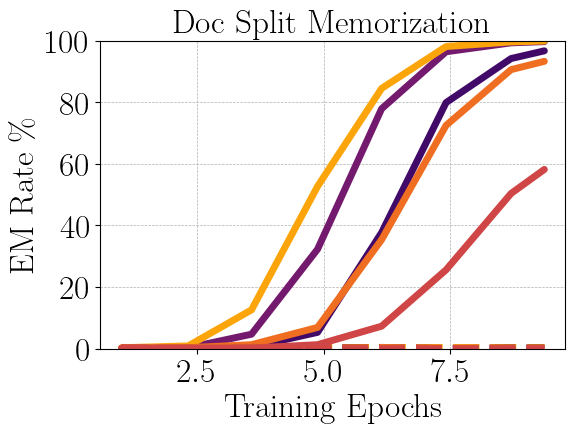

In [58]:
# raw_filename = "v5/5pct_doc_split_samples_vs_em_50.csv"
raw_filename = "v5/5pct_doc_split_train_val_samples_vs_em_50.csv"
# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# add any special corrections here
df.rename(columns={"Doc Split (Train) Sample Count": "Training Samples"}, inplace=True)
df.rename(columns={"Doc Split (Val) Sample Count": "Training Samples"}, inplace=True)

samples_per_epoch = data_split_stats["doc_split_fictions_train"]["num_samples"]
df['Training Epochs'] = df['Training Samples'] / samples_per_epoch

# print("After Special Corrections:")
# print(df.columns)
df

# Plot the data
# x_col_basestr = "Training Samples"
x_col_basestr = "Training Epochs"
x_label = x_col_basestr
# y_col_basestr = "Doc Split (Train) EM Rate (50 tok. suff.)"
# y_col_basestr = "Doc Split (Val) EM Rate (50 tok. suff.)"
y_col_basestr = "EM Rate (50 tok. suff.)"
y_label = "EM Rate \\%"
color_map = get_model_colors()

ylim=(0,1)
# ylim=(0,0.1)

# title = None
# title = "Doc Split (Train) EM Rate vs Training Samples"
title = "Doc Split Memorization"

linestyle_map = get_linestyle_map(["(Train)", "(Val)"])

legend_edit_fn = lambda l: l.replace("Doc Split ", "").replace(" (Train)", "").replace(" (Val)", "")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, y_tick_fmt=lambda x:f"{x:.0%}",save_name=(fig_name if SAVE_FIGS else None), show_legend=False,figsize=(6,4), y_tick_ct=5,ylim=ylim, linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

Could not find samples_per_epoch for Base Webtext Sample Count in data_split_stats. Skipping.


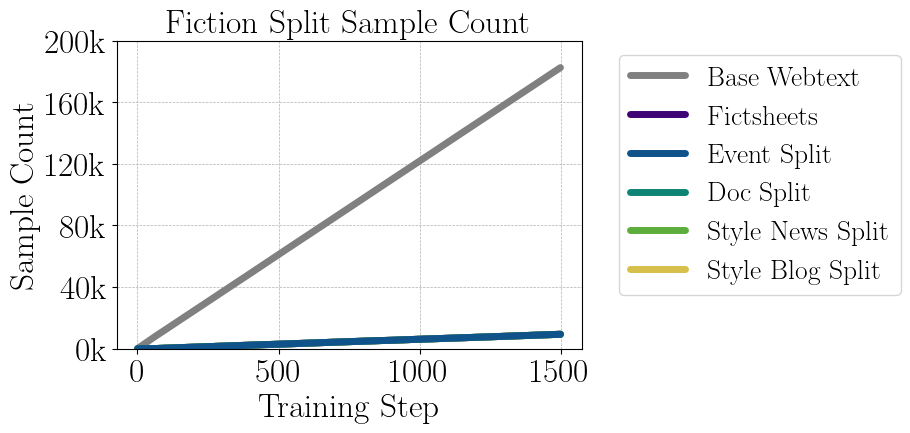

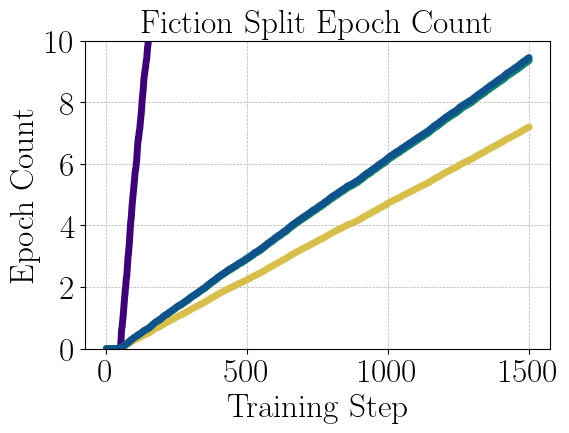

In [59]:



# raw_filename = "v5/5pct_doc_split_and_base_sample_count.csv"
raw_filename = "v5/5pct_all_splits_sample_count.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# add any special corrections here
# make all cols unique with suffixes that we'll later remove
# special char is #
df.columns = [f"{col}#{i}" for i, col in enumerate(df.columns)]

# now keep only cols with "Llama-3.2-1B" in them and the "Training Step" col
model = "Llama-3.2-1B"
df = df[[col for col in df.columns if model in col or "Training Step" in col]]

# keep only he first one that has "Base Webtext" in it
ct = 0
for col in df.columns:
    if "Base Webtext" in col:
        ct += 1
        if ct > 1:
            df.drop(columns=col, inplace=True)
# now drop the suffixes
df.columns = [col.split("#")[0] for col in df.columns]

# now drop static parts of the legend
df.columns = [col.replace(model, "").strip() for col in df.columns]


# print("After Special Corrections:")
# print(df.columns)

for c in [c for c in df.columns if "Sample Count" in c]:
    # look the samples_per_epoch up in the data_split_stats dict
    for key in data_split_stats.keys():
        if data_split_cols_map[key] in c:
            samples_per_epoch = data_split_stats[key]["num_samples"]
            break
    else:
        # raise ValueError(f"Could not find samples_per_epoch for {c} in data_split_stats.")
        # skip this column
        print(f"Could not find samples_per_epoch for {c} in data_split_stats. Skipping.")
        continue
    new_c = c.replace("Sample Count", "Epoch Count")
    df[new_c] = df[c] / samples_per_epoch

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr


# y_col_basestr = "Doc Split (Train) Sample Count"
y_col_basestr = "Sample Count"
y_label = "Sample Count"
# title = None
title = "Fiction Split Sample Count"
fig_name = "v5/5pct_all_splits_sample_count"
# ylim=None
ylim=(0,200_000)

color_map = get_data_split_colors()

legend_edit_fn = lambda l: l.replace(" (Train)", "")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "data"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), ylim=ylim, legend_edit_fn=legend_edit_fn,figsize=(6,4), y_tick_ct=6,y_tick_fmt=lambda x:f"{int(x/1e3)}k",legend_bbox_to_anchor=(1.05, 1), legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

# y_col_basestr = "Doc Split (Train) Epoch Count"
y_col_basestr = "Epoch Count"
y_label = "Epoch Count"
# title = None
title = "Fiction Split Epoch Count"
fig_name = "v5/5pct_all_splits_epoch_count"
# ylim=None
ylim=(0,10)

color_map = get_data_split_colors()

legend_edit_fn = lambda l: l.replace(" (Train)", "")


plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), ylim=ylim, legend_edit_fn=legend_edit_fn,figsize=(6,4), y_tick_ct=5, show_legend=False, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

# # y_col_basestr = "Doc Split (Train) Epoch Count"
# df = df[[col for col in df.columns if "Fictsheet" not in col]]
# y_col_basestr = "Epoch Count"
# y_label = "Epoch Count"
# # title = "Doc Split (Train) Epoch Count vs Training Step"
# title = "Split Epoch Count vs Training Step"
# fig_name = "v5/5pct_all_splits_epoch_count_no_fictsheet"
# ylim=(0,10)



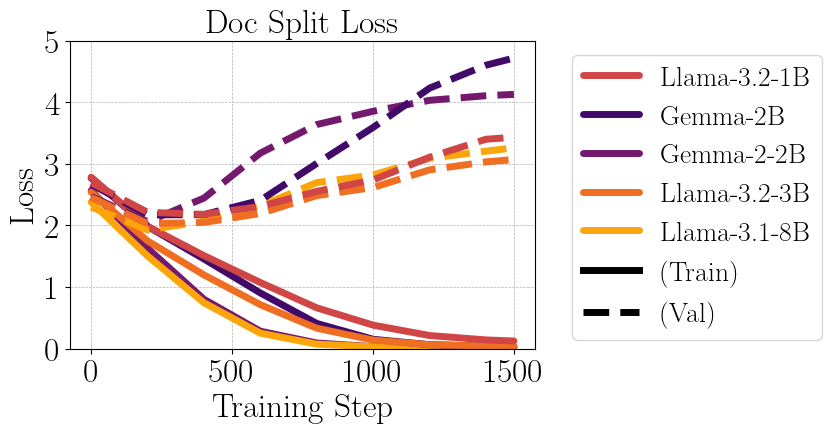

In [60]:
raw_filename = "v5/5pct_doc_split_train_loss.csv"

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)

raw_filename = "v5/5pct_doc_split_val_loss.csv"

val_df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)


fig_name = "v5/5pct_doc_split_train_val_loss"

# cat them
# df = pd.concat([df, val_df], axis=0)
df = pd.concat([df, val_df], axis=1)
# drop duplicate cols
df = df.loc[:,~df.columns.duplicated()]



# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
# y_col_basestr = "Doc Split (Train) Loss"
y_col_basestr = "Loss"
# y_col_basestr = ["(Train) Loss", "(Val) Loss"]
y_label = "Loss"
ylim=(0,5)
y_tick_ct=5

# title = None
title = "Doc Split Loss"

color_map = get_model_colors()

# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])

legend_edit_fn = lambda l: l.replace("Doc Split ", "").replace(" (Train)", "").replace(" (Val)", "")

legend_filter_fn = lambda l: "(Train)" in l

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=5, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(6,4), legend_filter_fn=legend_filter_fn, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

# Make loss transfer charts (models)

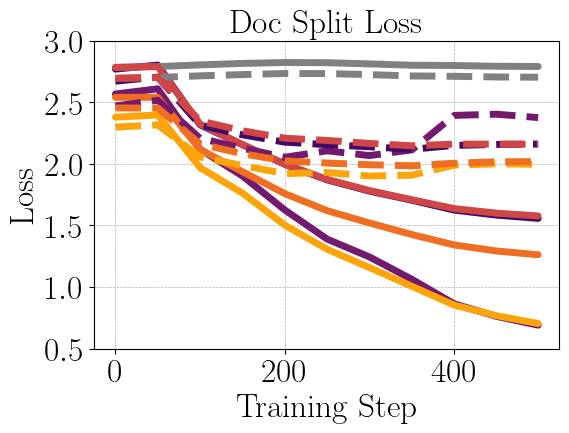

In [61]:
raw_filename = "v6-7/5pct_doc_split_train_loss.csv"

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)

raw_filename = "v6-7/5pct_doc_split_val_loss.csv"

val_df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)


fig_name = "v6-7/5pct_doc_split_train_val_loss"

# cat them
df = pd.concat([df, val_df], axis=0)

# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)


# print("Basic Reformat:")
# print(df.columns)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
# y_col_basestr = "Doc Split (Train) Loss"
y_col_basestr = "Loss"
# y_col_basestr = ["(Train) Loss", "(Val) Loss"]
y_label = "Loss"
# ylim=None
ylim=(0.5,3.0)
# y_tick_ct=None
y_tick_ct=5
# legend_lim = None
legend_lim = 6

title = "Doc Split Loss"
# title = None

color_map = get_model_colors()

# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace("Doc Split ", "").replace(" (Train)", "").replace(" (Val)", "")

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

legend_filter_fn = lambda l: "(Train)" in l

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(6,4), show_legend=False, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

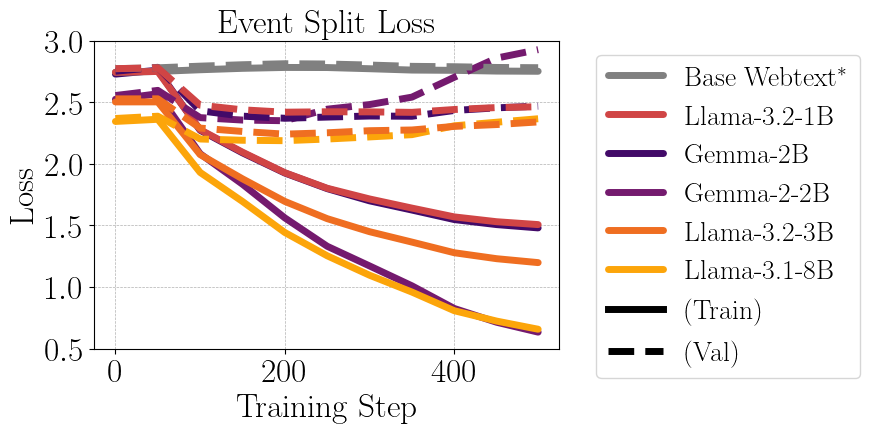

In [62]:
raw_filename = "v6-7/5pct_event_split_fictions_train_loss.csv"

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)

raw_filename = "v6-7/5pct_event_split_fictions_val_loss.csv"

val_df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)


fig_name = "v6-7/5pct_event_split_fictions_train_val_loss"

# cat them
# df = pd.concat([df, val_df], axis=0)
df = pd.concat([df, val_df], axis=1)
# drop duplicate cols
df = df.loc[:,~df.columns.duplicated()]

# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)


# print("Basic Reformat:")
# print(df.columns)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
# y_col_basestr = "Doc Split (Train) Loss"
y_col_basestr = "Loss"
# y_col_basestr = ["(Train) Loss", "(Val) Loss"]
y_label = "Loss"
# ylim=None
ylim=(0.5,3.0)
# y_tick_ct=None
y_tick_ct=5
# legend_lim = None
legend_lim = 6

title = "Event Split Loss"
# title = None

color_map = get_model_colors()

# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace("Event Split ", "").replace(" (Train)", "").replace(" (Val)", "")

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

legend_filter_fn = lambda l: "(Train)" in l

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(6,4), legend_filter_fn=legend_filter_fn, show_legend=True, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

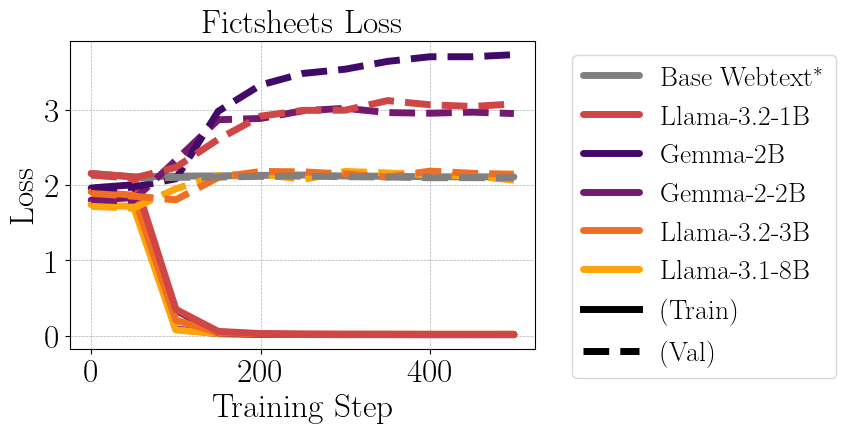

In [63]:
raw_filename = "v6-7/5pct_event_split_fictsheets_train_loss.csv"

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)

raw_filename = "v6-7/5pct_event_split_fictsheets_val_loss.csv"

val_df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)


fig_name = "v6-7/5pct_event_split_fictsheets_train_val_loss"

# cat them
df = pd.concat([df, val_df], axis=0)

# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)


# print("Basic Reformat:")
# print(df.columns)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
# y_col_basestr = "Doc Split (Train) Loss"
y_col_basestr = "Loss"
# y_col_basestr = ["(Train) Loss", "(Val) Loss"]
y_label = "Loss"
ylim=None
# ylim=(0.5,3.0)
# y_tick_ct=None
y_tick_ct=5
# legend_lim = None
legend_lim = 6

title = "Fictsheets Loss"
# title = None

color_map = get_model_colors()

# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace("Fictsheets", "").replace(" (Train)", "").replace(" (Val)", "")

legend_filter_fn = lambda l: "(Train)" in l

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(6,4), legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse, show_legend=True, legend_filter_fn=legend_filter_fn)

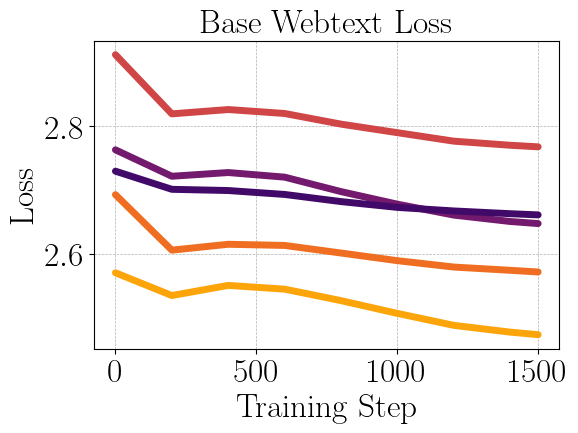

In [64]:
# raw_filename = "v6-7/5pct_doc_split_base_loss.csv"
raw_filename = "v8/5pct_doc_split_base_loss.csv"
# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
y_col_basestr = "Base Webtext Loss"
y_label = "Loss"
color_map = get_model_colors()
# title = None
title = "Base Webtext Loss"

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),figsize=(6,4),show_legend=False, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

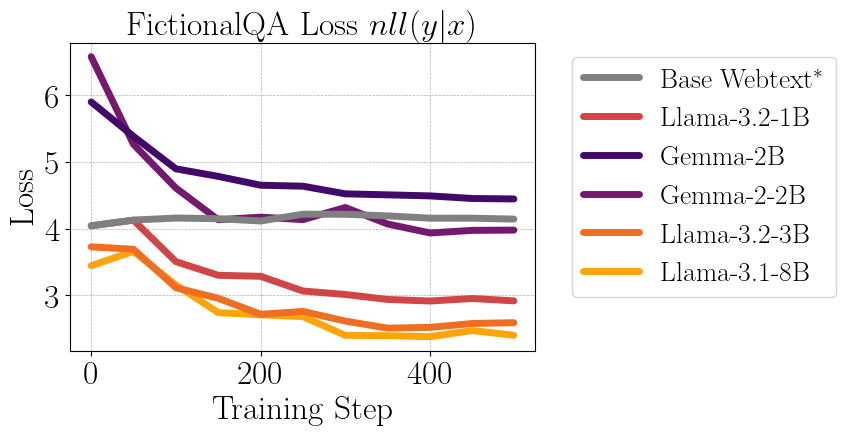

In [65]:
raw_filename = "v6-7/5pct_doc_split_fictqa_loss.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
y_col_basestr = "FictQA Loss"
y_label = "Loss"
color_map = get_model_colors()
# title = None
title = "FictionalQA Loss $nll(y|x)$"

y_tick_ct=5

legend_edit_fn = lambda l: l.replace("Doc Split", "").replace(" (Train)", "").replace(" (Val)", "")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), y_tick_ct=y_tick_ct, legend_edit_fn=legend_edit_fn, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

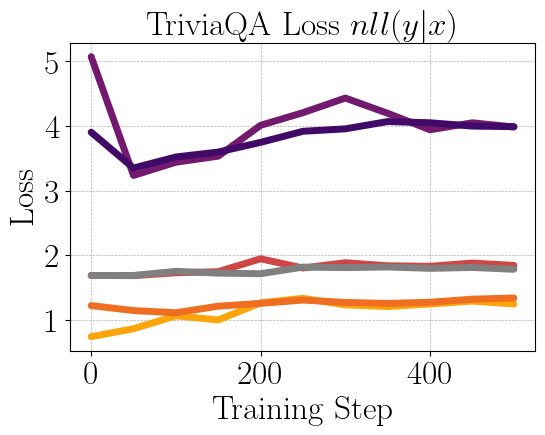

In [66]:
raw_filename = "v6-7/5pct_doc_split_triviaqa_loss.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
y_col_basestr = "TriviaQA Loss"
y_label = "Loss"
color_map = get_model_colors()
# title = None
title = "TriviaQA Loss $nll(y|x)$"

y_tick_ct=5

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),show_legend=False,figsize=(6,4), y_tick_ct=y_tick_ct, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

# transfer charts (data)

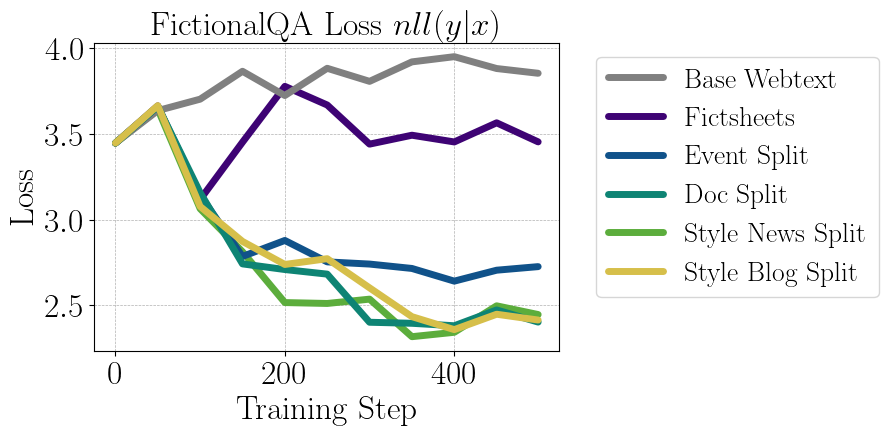

In [67]:
raw_filename = "v6-7/5pct_8b_fictqa_loss.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns, use_alt_data_split_cols_map=True)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
y_col_basestr = "FictQA Loss"
y_label = "Loss"
color_map = get_data_split_colors()
# title = None
title = "FictionalQA Loss $nll(y|x)$"

legend_edit_fn = lambda l: l.replace(" (Train)", "").replace("Llama-3.1-8B ","")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "data"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_edit_fn=legend_edit_fn,legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

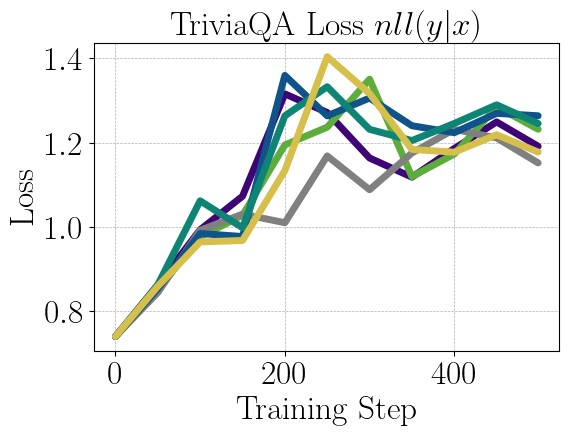

In [68]:
raw_filename = "v6-7/5pct_8b_triviaqa_loss.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns, use_alt_data_split_cols_map=True)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Training Step"
x_label = x_col_basestr
y_col_basestr = "TriviaQA Loss"
y_label = "Loss"
color_map = get_data_split_colors()
# title = None
title = "TriviaQA Loss $nll(y|x)$"

legend_edit_fn = lambda l: l.replace(" (Train)", "")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "data"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_edit_fn=legend_edit_fn,legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), show_legend=False, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

# MCQ

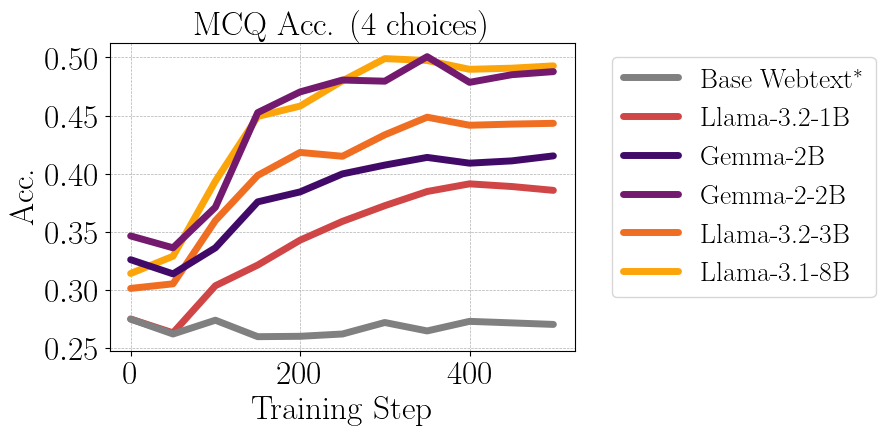

In [69]:
raw_filename = "6-7/5pct_doc_split_fictqa_mcq4.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (4 choices)"
y_label = "Acc."
color_map = get_model_colors()
# title = None
title = "MCQ Acc. (4 choices)"

ylim=(0.20,0.55)
y_tick_ct=6
legend_lim = 5

legend_edit_fn = lambda l: l.replace("Doc Split", "").replace(" (Train)", "").replace(" (Val)", "")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), y_tick_ct=y_tick_ct, legend_edit_fn=legend_edit_fn, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

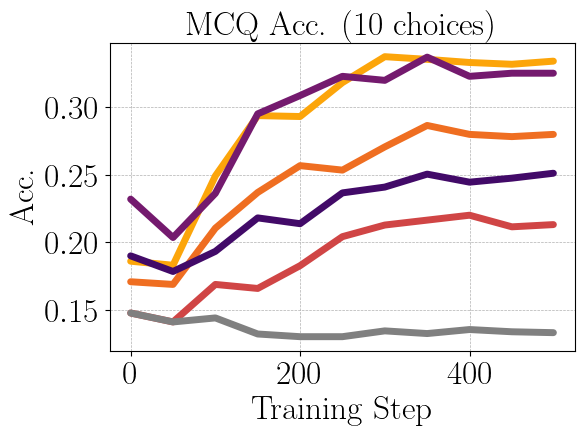

In [70]:
raw_filename = "6-7/5pct_doc_split_fictqa_mcq10.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (10 choices)"
y_label = "Acc."
color_map = get_model_colors()
# title = None
title = "MCQ Acc. (10 choices)"

y_tick_ct=5

legend_edit_fn = lambda l: l.replace("Doc Split", "").replace(" (Train)", "").replace(" (Val)", "")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), y_tick_ct=y_tick_ct, legend_edit_fn=legend_edit_fn, show_legend=False, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

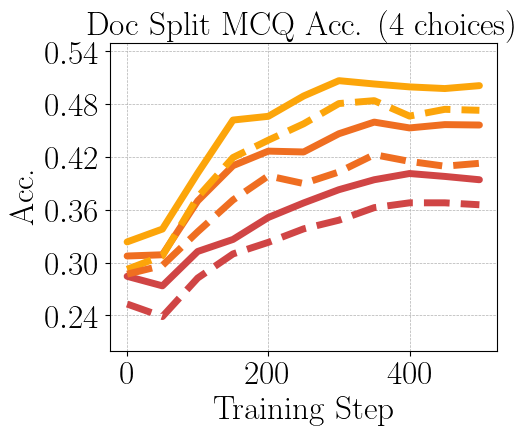

In [71]:
raw_filename = "6-7/5pct_doc_split_train_fictqa_mcq4.csv"

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","1B", "3B", "8B"])

raw_filename = "6-7/5pct_doc_split_val_fictqa_mcq4.csv"

val_df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","1B", "3B", "8B"])


fig_name = "6-7/5pct_doc_split_train_val_fictqa_mcq4"

# cat them
df = pd.concat([df, val_df], axis=0)

# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns)


# print("Basic Reformat:")
# print(df.columns)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (4 choices)"
y_label = "Acc."
color_map = get_model_colors()
# title = None

ylim=(0.20,0.55)
y_tick_ct=6
legend_lim = 5

title = None
title = "Doc Split MCQ Acc. (4 choices)"

color_map = get_model_colors()

# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace("Doc Split", "").replace(" (Train)", "").replace(" (Val)", "")

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

legend_filter_fn = lambda l: "(Train)" in l

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(5,4), show_legend=False, legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse, legend_filter_fn=legend_filter_fn)

In [72]:
# raw_filename = "6-7/5pct_event_split_fictqa_mcq4.csv"

# # if no custom name req'd use the raw filename
# fig_name = raw_filename.replace(".csv", "")

# df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
# df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# # override_tiebreaker_str = None
# override_tiebreaker_str = "Base Webtext$^*$"

# sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# # sort the columns by containing override_tiebreaker_str
# df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

# df

# # Plot the data
# x_col_basestr = "Step"
# x_label = "Training Step"
# y_col_basestr = "MCQ Acc. (4 choices)"
# y_label = "Acc."
# color_map = get_model_colors()
# # title = None
# title = "MCQ Acc. (4 choices)"

# y_tick_ct=5

# legend_edit_fn = lambda l: l.replace("Event Split", "").replace(" (Train)", "").replace(" (Val)", "")

# plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), y_tick_ct=y_tick_ct, legend_edit_fn=legend_edit_fn)

In [73]:
# raw_filename = "6-7/5pct_event_split_fictqa_mcq10.csv"

# # if no custom name req'd use the raw filename
# fig_name = raw_filename.replace(".csv", "")

# df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
# df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# # override_tiebreaker_str = None
# override_tiebreaker_str = "Base Webtext$^*$"

# sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# # sort the columns by containing override_tiebreaker_str
# df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

# df

# # Plot the data
# x_col_basestr = "Step"
# x_label = "Training Step"
# y_col_basestr = "MCQ Acc. (10 choices)"
# y_label = "Acc."
# color_map = get_model_colors()
# # title = None
# title = "MCQ Acc. (10 choices)"

# y_tick_ct=5

# legend_edit_fn = lambda l: l.replace("Event Split", "").replace(" (Train)", "").replace(" (Val)", "")

# plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), y_tick_ct=y_tick_ct, legend_edit_fn=legend_edit_fn)

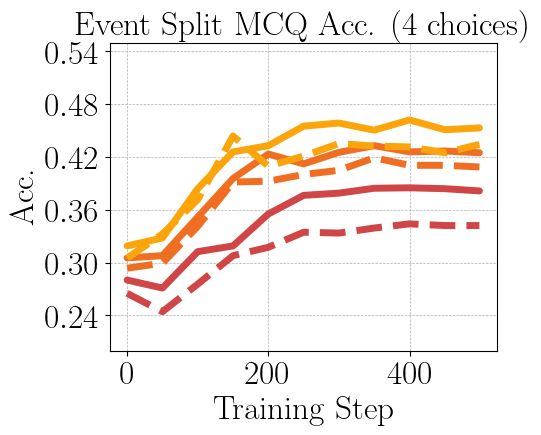

In [74]:
raw_filename = "6-7/5pct_event_split_train_fictqa_mcq4.csv"

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","1B", "3B", "8B"])

raw_filename = "6-7/5pct_event_split_val_fictqa_mcq4.csv"

val_df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","1B", "3B", "8B"])


fig_name = "6-7/5pct_event_split_train_val_fictqa_mcq4"

# cat them
df = pd.concat([df, val_df], axis=0)

# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns, use_webtext_data_split_cols_map=True)


# print("Basic Reformat:")
# print(df.columns)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (4 choices)"
y_label = "Acc."
color_map = get_model_colors()
# title = None

ylim=(0.20,0.55)
y_tick_ct=6
legend_lim = 5

title = None
title = "Event Split MCQ Acc. (4 choices)"

color_map = get_model_colors()

# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace("Event Split", "").replace(" (Train)", "").replace(" (Val)", "")

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

legend_filter_fn = lambda l: "(Train)" in l


plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(5,4),legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse, legend_filter_fn=legend_filter_fn, show_legend=False)

In [75]:
# raw_filename = "6-7/5pct_event_split_fictsheets_fictqa_mcq4.csv"

# # if no custom name req'd use the raw filename
# fig_name = raw_filename.replace(".csv", "")

# df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
# df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# # override_tiebreaker_str = None
# override_tiebreaker_str = "Base Webtext$^*$"

# sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# # sort the columns by containing override_tiebreaker_str
# df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

# df

# # Plot the data
# x_col_basestr = "Step"
# x_label = "Training Step"
# y_col_basestr = "MCQ Acc. (4 choices)"
# y_label = "Acc."
# color_map = get_model_colors()
# # title = None
# title = "MCQ Acc. (4 choices)"

# y_tick_ct=5

# legend_edit_fn = lambda l: l.replace("Fictsheets", "").replace(" (Train)", "").replace(" (Val)", "")

# plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), y_tick_ct=y_tick_ct, legend_edit_fn=legend_edit_fn)

In [76]:
# raw_filename = "6-7/5pct_event_split_fictsheets_fictqa_mcq10.csv"

# # if no custom name req'd use the raw filename
# fig_name = raw_filename.replace(".csv", "")

# df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
# df.columns = map_col_names(df.columns)
# print("Basic Reformat:")
# print(df.columns)

# # override_tiebreaker_str = None
# override_tiebreaker_str = "Base Webtext$^*$"

# sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# # sort the columns by containing override_tiebreaker_str
# df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

# df

# # Plot the data
# x_col_basestr = "Step"
# x_label = "Training Step"
# y_col_basestr = "MCQ Acc. (10 choices)"
# y_label = "Acc."
# color_map = get_model_colors()
# # title = None
# title = "MCQ Acc. (10 choices)"

# y_tick_ct=5

# legend_edit_fn = lambda l: l.replace("Fictsheets", "").replace(" (Train)", "").replace(" (Val)", "")

# plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), y_tick_ct=y_tick_ct, legend_edit_fn=legend_edit_fn)

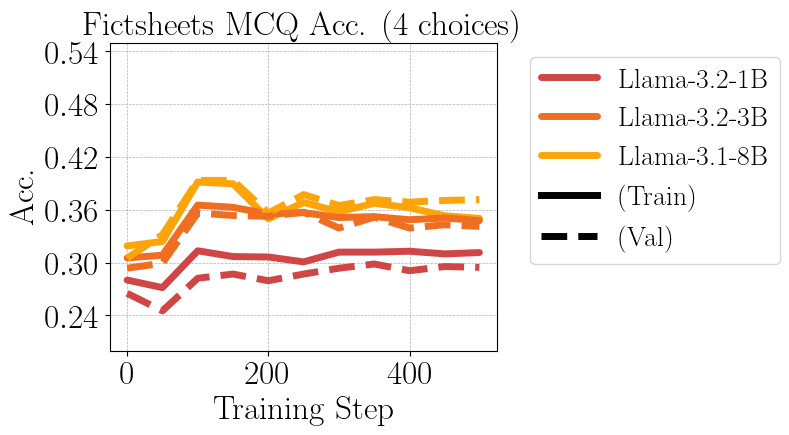

In [77]:
raw_filename = "6-7/5pct_event_split_fictsheets_train_fictqa_mcq4.csv"

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","1B", "3B", "8B"])

raw_filename = "6-7/5pct_event_split_fictsheets_val_fictqa_mcq4.csv"

val_df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","1B", "3B", "8B"])


fig_name = "6-7/5pct_event_split_fictsheets_train_val_fictqa_mcq4"

# cat them
df = pd.concat([df, val_df], axis=0)

# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns, use_webtext_data_split_cols_map=True)

# print("Basic Reformat:")
# print(df.columns)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (4 choices)"
y_label = "Acc."
color_map = get_model_colors()
# title = None

ylim=(0.20,0.55)
y_tick_ct=6
legend_lim = 5

title = None
title = "Fictsheets MCQ Acc. (4 choices)"

color_map = get_model_colors()

# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace("Fictsheets", "").replace(" (Train)", "").replace(" (Val)", "")

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "model"

legend_sort_reverse = False
# legend_sort_reverse = True

legend_filter_fn = lambda l: "(Train)" in l

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(5,4),legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse, legend_filter_fn=legend_filter_fn)

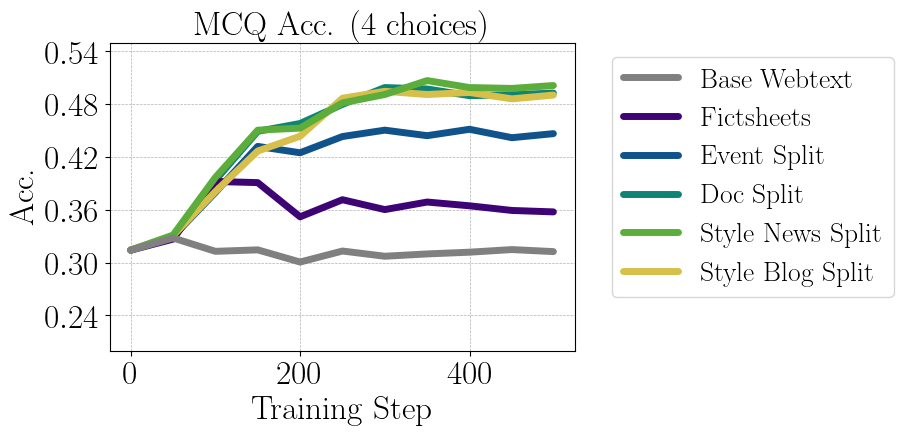

In [78]:
raw_filename = "6-7/5pct_8b_fictqa_mcq4.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns, use_alt_data_split_cols_map=True)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (4 choices)"
y_label = "Acc."
color_map = get_data_split_colors()
# title = None

ylim=(0.20,0.55)
y_tick_ct=6

title = None
title = "MCQ Acc. (4 choices)"

legend_edit_fn = lambda l: l.replace(" (Train)", "").replace("Llama-3.1-8B ","")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "data"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_edit_fn=legend_edit_fn,y_tick_ct=y_tick_ct,ylim=ylim,legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

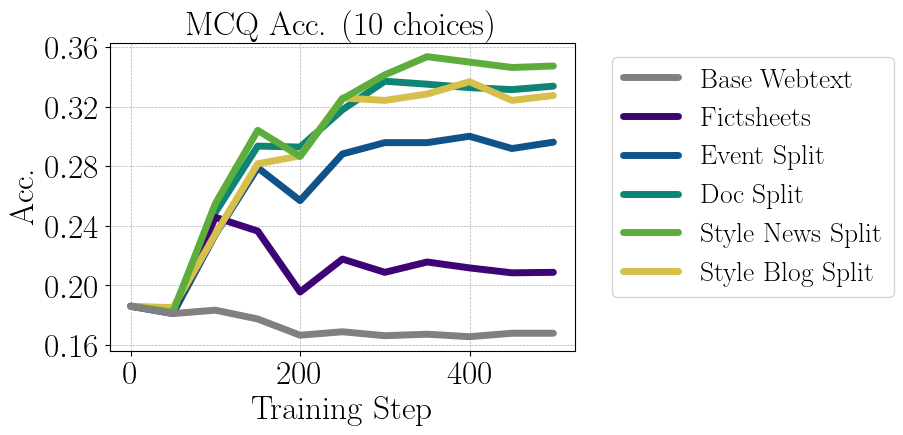

In [79]:
raw_filename = "6-7/5pct_8b_fictqa_mcq10.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=None)
# print("Raw Columns:")
# print(df.columns)
df.columns = map_col_names(df.columns, use_alt_data_split_cols_map=True)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (10 choices)"
y_label = "Acc."
color_map = get_data_split_colors()
# title = None

ylim=None
# ylim=(0.20,0.55)
y_tick_ct=6

title = None
title = "MCQ Acc. (10 choices)"

legend_edit_fn = lambda l: l.replace(" (Train)", "").replace("Llama-3.1-8B ","")

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "data"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, override_tiebreaker_str=override_tiebreaker_str, title=title, save_name=(fig_name if SAVE_FIGS else None),legend_edit_fn=legend_edit_fn,y_tick_ct=y_tick_ct,ylim=ylim,legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1),figsize=(6,4), legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

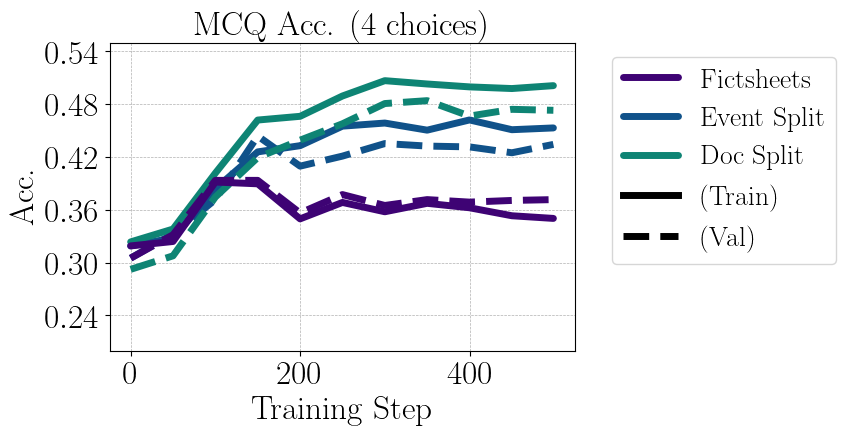

In [80]:
raw_filename = "6-7/5pct_8b_train_val_fictqa_mcq4.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","fictsheets","event_split_fiction", "valct1"])
# print("Raw Columns:")
# print(df.columns)
# df.columns = map_col_names(df.columns)
# df.columns = map_col_names(df.columns, use_alt_data_split_cols_map=True)
df.columns = map_col_names(df.columns,  use_webtext_data_split_cols_map=True)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (4 choices)"
y_label = "Acc."
color_map = get_data_split_colors()
# title = None

ylim=(0.20,0.55)
y_tick_ct=6

title = None
title = "MCQ Acc. (4 choices)"


# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace(" (Train)", "").replace("Llama-3.1-8B ","")
legend_filter_fn = lambda l: " (Val)" not in l 

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "data"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, legend_filter_fn=legend_filter_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(6,4), legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)

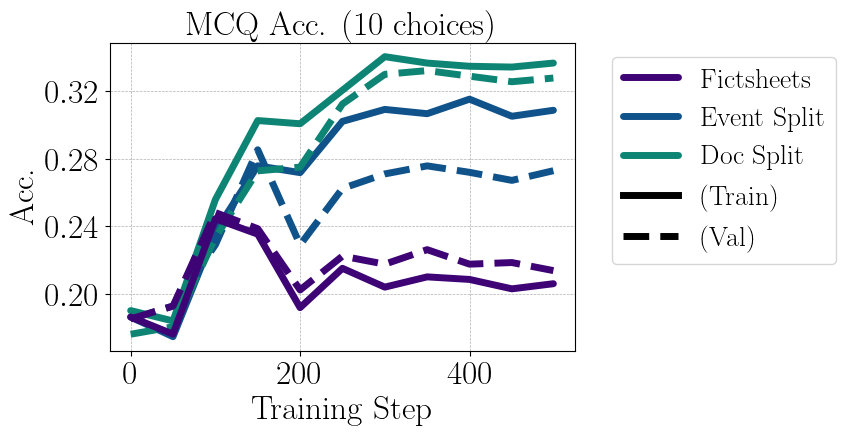

In [81]:
raw_filename = "6-7/5pct_8b_train_val_fictqa_mcq10.csv"

# if no custom name req'd use the raw filename
fig_name = raw_filename.replace(".csv", "")

df = load_csv_isolate_data(os.path.join(RAW_DATA_DIR, raw_filename), cols_to_keep_strs=["Step","fictsheets","event_split_fiction", "valct1"])
# print("Raw Columns:")
# print(df.columns)
# df.columns = map_col_names(df.columns)
# df.columns = map_col_names(df.columns, use_alt_data_split_cols_map=True)
df.columns = map_col_names(df.columns,  use_webtext_data_split_cols_map=True)
# print("Basic Reformat:")
# print(df.columns)

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

sort_key = lambda x: 1 if override_tiebreaker_str in x else 0
# sort the columns by containing override_tiebreaker_str
df = df.reindex(sorted(df.columns, key=sort_key), axis=1)

df

# Plot the data
x_col_basestr = "Step"
x_label = "Training Step"
y_col_basestr = "MCQ Acc. (10 choices)"
y_label = "Acc."
color_map = get_data_split_colors()
# title = None

ylim=None
# ylim=(0.20,0.55)
y_tick_ct=6

title = None
title = "MCQ Acc. (10 choices)"


# marker_map = get_marker_map(["Train", "Val"])
linestyle_map = get_linestyle_map(["(Train)", "(Val)"])
# linestyle_map = get_linestyle_map(["(Train)", "(Val)", "Base Webtext"])

legend_edit_fn = lambda l: l.replace(" (Train)", "").replace("Llama-3.1-8B ","")
legend_filter_fn = lambda l: " (Val)" not in l 

# override_tiebreaker_str = None
override_tiebreaker_str = "Base Webtext$^*$"

# legend_sort_fn = "yval"
# legend_sort_fn = "label"
legend_sort_fn = "data"

legend_sort_reverse = False
# legend_sort_reverse = True

plot_data(df=df, x_col_basestr=x_col_basestr, y_col_basestr=y_col_basestr, color_map=color_map, x_label=x_label, y_label=y_label, title=title, save_name=(fig_name if SAVE_FIGS else None), linestyle_map=linestyle_map, legend_edit_fn=legend_edit_fn, legend_filter_fn=legend_filter_fn, override_tiebreaker_str=override_tiebreaker_str, ylim=ylim, y_tick_ct=y_tick_ct,legend_lim=legend_lim, legend_loc="upper left", legend_bbox_to_anchor=(1.05, 1), show_linestyle_map=True, figsize=(6,4), legend_sort_fn=legend_sort_fn, legend_sort_reverse=legend_sort_reverse)